In [1]:
from logger import MyLogger
import time
import SubjObjLoader
import json
from torch import nn
import torch
from pytorch_transformers import *
import importlib
from collections import deque
# import dataloader
from BertRDMLoader import *
import json
from torch import nn
import torch
from pytorch_transformers import *
import importlib
from tensorboardX import SummaryWriter
import torch.nn.utils.rnn as rnn_utils
import tsentiLoader

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### 工具函数

#### 画柱状图表达特征指标的变化

In [3]:
def plot_heatmap(heatmap, data_label, heat_max, heat_min):
    #attention: [batch, seq_len]
    #data_label: [batch]
    batch = len(data_label)
    height = 0.5
    plt.figure(figsize=(50, batch*height))
    plt.ylim(0, batch*height)
    plt.xlim(0, 50)
    plt.yticks(np.arange(0, batch*height, height), data_label)
    plt.yticks(np.arange(0, 50, 5), ['']*10)
    for idx, h in enumerate(heatmap):
        color_list = [((b-heat_min)*1.0/(heat_max - heat_min), 0.0, 0.0) for b in h]
        d = np.arange(0, 50, 49.99/len(h)).tolist()
        d.reverse()
        color_list.reverse()
        for color, length in zip(color_list, d):
            plt.barh([idx*0.5], length, 1.0, color=color) 
    plt.show()

In [4]:
heat = [np.random.randint(5, size = [np.random.randint(5, 100)]).tolist() for i in range(100)]

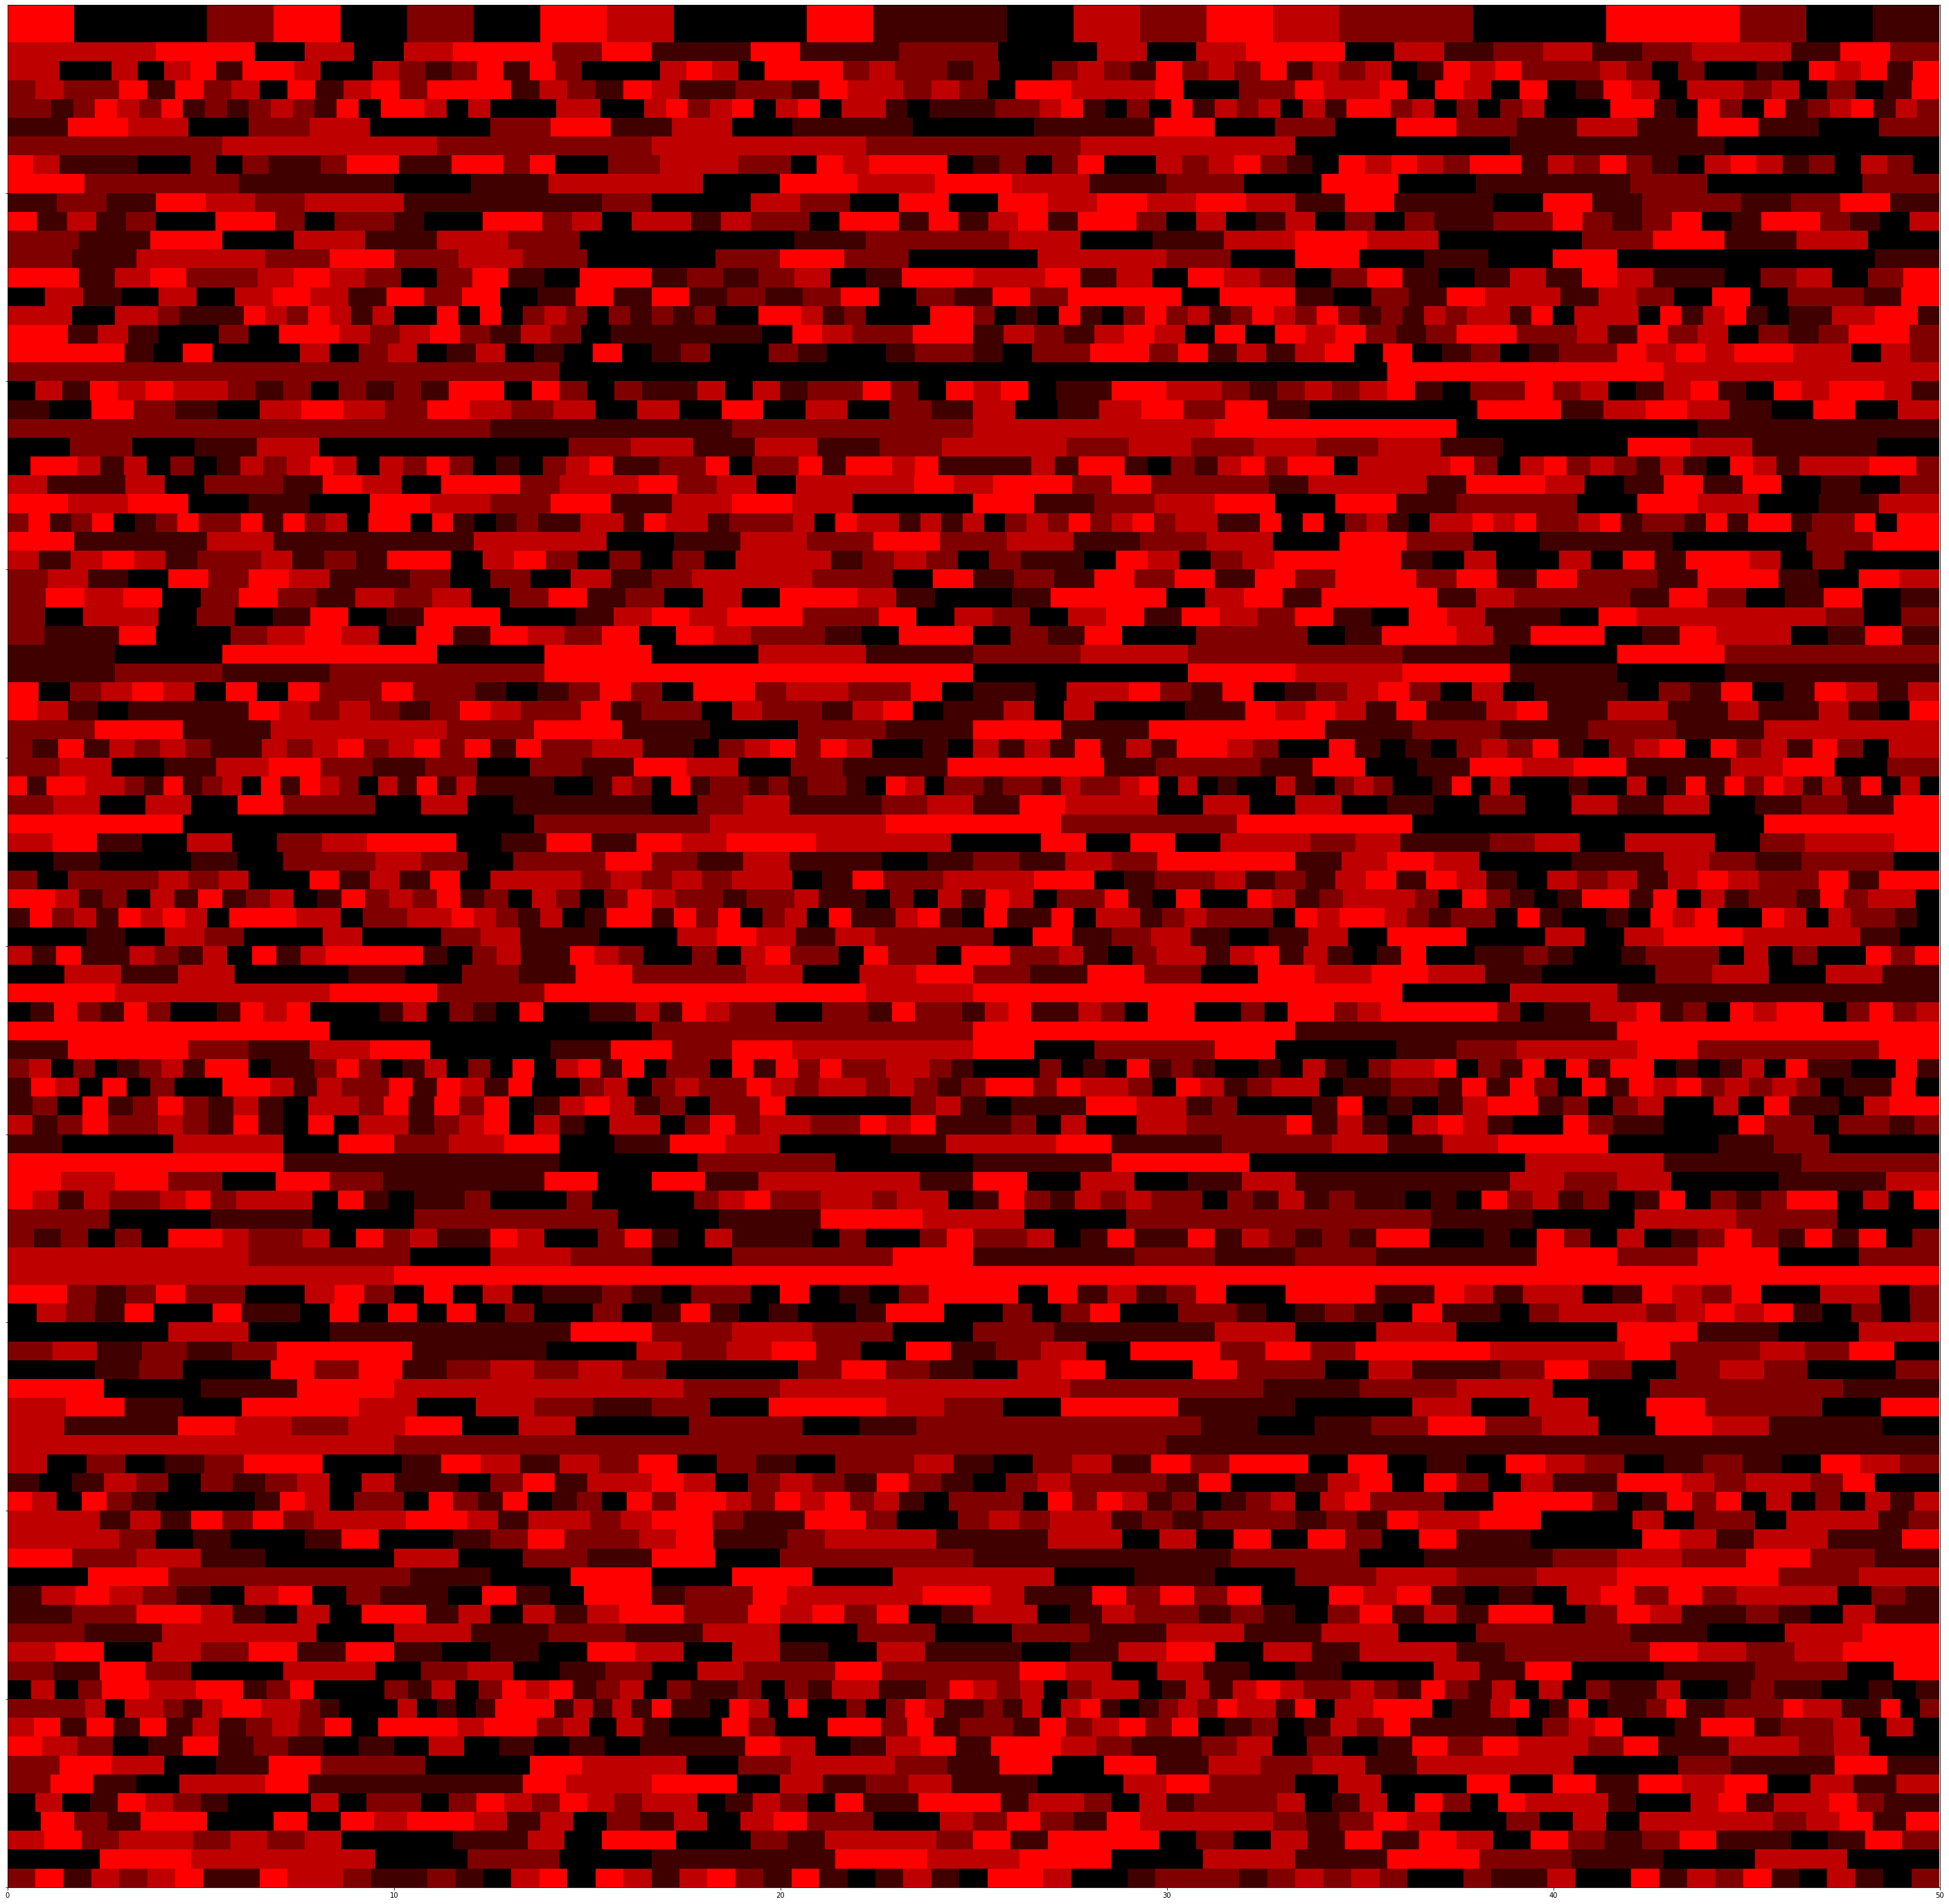

In [5]:
plot_heatmap(heat, list(range(100)), 4, 0)

### 旧模型的评价

bert没有分到多块GPU上去进行计算

In [6]:
class pooling_layer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(pooling_layer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def forward(self, inputs):
        assert(inputs.ndim == 4 ) # [batchsize, max_seq_len, max_word_num, input_dim] 
        batch_size, max_seq_len, max_word_num, input_dim = inputs.shape
        assert(input_dim == self.input_dim)
        t_inputs = inputs.reshape([-1, self.input_dim])
        return self.linear(t_inputs).reshape(
            
            [-1, max_word_num, self.output_dim]
        
        ).max(axis=1)[0].reshape(
        
            [-1, max_seq_len, self.output_dim]
        
        )

class RDM_Model(nn.Module):
    def __init__(self, word_embedding_dim, sent_embedding_dim, hidden_dim, dropout_prob):
        super(RDM_Model, self).__init__()
        self.embedding_dim = sent_embedding_dim
        self.hidden_dim = hidden_dim
        self.gru_model = nn.GRU(word_embedding_dim, 
                                self.hidden_dim, 
                                batch_first=True, 
                                dropout=dropout_prob
                            )
        self.DropLayer = nn.Dropout(dropout_prob)
#         self.PoolLayer = pooling_layer(word_embedding_dim, sent_embedding_dim) 
        
    def forward(self, x_emb, x_len, init_states): 
        """
        input_x: [batchsize, max_seq_len, sentence_embedding_dim] 
        x_emb: [batchsize, max_seq_len, 1, embedding_dim]
        x_len: [batchsize]
        init_states: [batchsize, hidden_dim]
        """
        batchsize, max_seq_len, _ , emb_dim = x_emb.shape
#         pool_feature = self.PoolLayer(x_emb)
#         sent_feature = sentiModel( 
#                 x_emb.reshape(
#                     [-1, max_sent_len, emb_dim]
#                 ) 
#             ).reshape(
#                 [batchsize, max_seq_len, -1]
#             )
#         pooled_input_x_dp = self.DropLayer(input_x)
        pool_feature = x_emb.reshape(
                [-1, max_seq_len, emb_dim]
        )
        df_outputs, df_last_state = self.gru_model(pool_feature, init_states)
        hidden_outs = [df_outputs[i][:x_len[i]] for i in range(batchsize)]
        final_outs = [df_outputs[i][x_len[i]-1] for i in range(batchsize)]
        return hidden_outs, final_outs


class CM_Model(nn.Module):
    def __init__(self, sentence_embedding_dim, hidden_dim, action_num):
        super(CM_Model, self).__init__()
        self.sentence_embedding_dim = sentence_embedding_dim
        self.hidden_dim = hidden_dim
        self.action_num = action_num
#         self.PoolLayer = pooling_layer(self.embedding_dim, 
#                                             self.hidden_dim)
        self.DenseLayer = nn.Linear(self.hidden_dim, 64)
        self.Classifier = nn.Linear(64, self.action_num)
        
    def forward(self, rdm_model, s_model, rl_input, rl_state):
        """
        rl_input: [batchsize, max_word_num, sentence_embedding_dim]
        rl_state: [1, batchsize, hidden_dim]
        """
        assert(rl_input.ndim==3)
        batchsize, max_word_num, embedding_dim = rl_input.shape
#         assert(embedding_dim==self.embedding_dim)
        sentence = s_model(rl_input).reshape(batch_size, 1, self.sentence_embedding_dim)
#         pooled_rl_input = self.PoolLayer(
#             rl_input.reshape(
#                 [-1, 1, max_word_num, self.embedding_dim]
#             )
#         ).reshape([-1, 1, self.hidden_dim])
        
#         print("sentence:", sentence.shape)
#         print("rl_state:", rl_state.shape)
        rl_output, rl_new_state = rdm_model.gru_model(
                                            sentence, 
                                            rl_state
                                        )
        rl_h1 = nn.functional.relu(
            self.DenseLayer(
#                 rl_state.reshape([len(rl_input), self.hidden_dim]) #it is not sure to take rl_state , rather than rl_output, as the feature
                rl_output.reshape(
                    [len(rl_input), self.hidden_dim]
                )
            )
        )
        stopScore = self.Classifier(rl_h1)
        isStop = stopScore.argmax(axis=1)
        return stopScore, isStop, rl_new_state


# In[3]:


def layer2seq(bert, layer, cuda=False):
    if cuda:
        outs = [bert( torch.tensor([input_]).cuda())
                for input_ in layer]   
    else: 
        outs = [bert( torch.tensor([input_]))
                    for input_ in layer]
    states = [item[1] for item in outs]
    return rnn_utils.pad_sequence(states, batch_first=True)

def Word_ids2SeqStates(word_ids, bert, ndim, cuda=False):
    assert(ndim == 3)
    if cuda:
        embedding = [layer2seq(bert, layer, cuda) for layer in word_ids]
    else:
        embedding = [layer2seq(bert, layer) for layer in word_ids]
    return padding_sequence(embedding)


# In[4]:


def Count_Accs(ylabel, preds):
    correct_preds = np.array(
        [1 if y1==y2 else 0 
        for (y1, y2) in zip(ylabel, preds)]
    )
    y_idxs = [idx if yl >0 else idx - len(ylabel) 
            for (idx, yl) in enumerate(ylabel)]
    pos_idxs = list(filter(lambda x: x >= 0, y_idxs))
    neg_idxs = list(filter(lambda x: x < 0, y_idxs))
    acc = sum(correct_preds) / (1.0 * len(ylabel))
    if len(pos_idxs) > 0:
        pos_acc = sum(correct_preds[pos_idxs])/(1.0*len(pos_idxs))
    else:
        pos_acc = 0
    if len(neg_idxs) > 0:
        neg_acc = sum(correct_preds[neg_idxs])/(1.0*len(neg_idxs))
    else:
        neg_acc = 0
    return acc, pos_acc, neg_acc, y_idxs, pos_idxs, neg_idxs, correct_preds

def Loss_Fn(ylabel, pred_scores):
    diff = ((ylabel - pred_scores)*(ylabel - pred_scores)).mean(axis=1)
#     pos_neg = (1.0*sum(ylabel.argmax(axis=1)))/(1.0*(len(ylabel) - sum(ylabel.argmax(axis=1))))
    pos_neg = 0
    if pos_neg > 0:
        print("unbalanced data")
        weight = torch.ones(len(ylabel)).cuda() + (ylabel.argmax(axis=1).to(torch.float32)/(1.0*pos_neg)) - ylabel.argmax(axis=1).to(torch.float32)
        return (weight *diff).mean()
    else:
        print("totally unbalanced data")
        return diff.mean()



In [7]:
def eval(rdm_model, bert, rdm_classifier, 
                    tokenizer, new_data_len=[]):
    batch_size = 20 
    d_IDs = get_data_ID()
    t_steps=int(len(d_IDs)/batch_size)
    
    max_gpu_batch = 2 #cannot load a larger batch into the limited memory, but we could  accumulates grads
    splits = int(batch_size/max_gpu_batch)
    assert(batch_size%max_gpu_batch == 0)
    sum_loss = 0.0
    sum_acc = 0.0
    init_states = torch.zeros([1, max_gpu_batch, rdm_model.hidden_dim], dtype=torch.float32).cuda()
    weight = torch.tensor([2.0, 1.0], dtype=torch.float32).cuda()
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    acc_l = np.zeros(splits)
    loss_l = np.zeros(splits)
    with torch.no_grad():
        for step in range(t_steps):
            try:
                for j in range(splits):
                    if len(new_data_len) > 0:
                        x, x_len, y = get_df_batch(step*splits+j, max_gpu_batch, new_data_len, tokenizer=tokenizer)
                    else:
                        x, x_len, y = get_df_batch(step, max_gpu_batch, tokenizer=tokenizer)
                    x_emb = Word_ids2SeqStates(x, bert, 3, cuda=True) 
                    batchsize, max_seq_len, max_sent_len,                                     emb_dim = x_emb.shape
                    rdm_hiddens, rdm_outs = rdm_model(x_emb, x_len, init_states)
                    rdm_scores = rdm_classifier(
                        torch.cat(
                            rdm_outs # a list of tensor, where the ndim of tensor is 1 and the shape of tensor is [hidden_size]
                        ).reshape(
                            [-1, rdm_model.hidden_dim]
                        )
                    )
                    rdm_preds = rdm_scores.argmax(axis=1)
                    y_label = y.argmax(axis=1)
                    acc_l[j], _, _, _, _, _, _ = Count_Accs(y_label, rdm_preds)
                    loss = loss_fn(rdm_scores, torch.tensor(y_label).cuda())
                    loss_l[j] = float(loss)
    #                 print("%d, %d | x_len:"%(step, j), x_len)
            except RuntimeError as exception:
                if "out of memory" in str(exception):
                    print("WARNING: out of memory")
                    print("%d, %d | x_len:"%(step, j), x_len)
                    if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
    #                     time.sleep(5)
                    raise exception
                else:   
                    raise exception
            sum_loss += loss_l.mean()
            sum_acc += acc_l.mean()
            print("loss:", loss_l.mean(), "acc:", acc_l.mean())
    mean_loss = sum_loss/(1.0*t_steps)
    mean_acc = sum_acc/(1.0*t_steps)
    print("mean_loss", mean_loss, " | mean_acc:", mean_acc)

In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", cached_dir = "/home/hadoop/transformer_pretrained_models/bert-base-uncased-pytorch_model.bin")

bert = BertModel.from_pretrained("bert-base-uncased").cuda()

with open("config.json", "r") as cr:
    dic = json.load(cr)

class adict(dict):
    ''' Attribute dictionary - a convenience data structure, similar to SimpleNamespace in python 3.3
        One can use attributes to read/write dictionary content.
    '''
    def __init__(self, *av, **kav):
        dict.__init__(self, *av, **kav)
        self.__dict__ = self

FLAGS = adict(dic)
# In[10]:
load_data_fast()

data_ID = get_data_ID()

len(data_ID)

data = get_data()

max_sent: 187 ,  max_seq_len: 101
5802 data loaded


#### 切分原数据集 | 3884: 200 :500

In [3]:
load_data_fast()

max_sent: 187 ,  max_seq_len: 101
5802 data loaded


_马晶那个数据集跟这个数据集差异太大，无法迁移_

``` python
data_ID = get_data_ID()
data_len = get_data_len()
data_y = get_data_y()

test_data_y = data_y[-500:]

test_data_len = data_len[-500:]

test_data_ID = data_ID[-500:]

np.save("data/data_ID.npy", np.array(data_ID)[:-500])
np.save("data/data_len.npy", np.array(data_len)[:-500])
np.save("data/data_y.npy", np.array(data_y)[:-500])

np.save("data/test_data_ID.npy", np.array(test_data_ID))
np.save("data/test_data_len.npy", np.array(test_data_len))
np.save("data/test_data_y.npy", np.array(test_data_y))
```

```python
data_ID = get_data_ID()
data_len = get_data_len()
data_y = get_data_y()

valid_data_y = data_y[-200:]

valid_data_len = data_len[-200:]

valid_data_ID = data_ID[-200:]

np.save("data/data_ID.npy", np.array(data_ID)[:-200])
np.save("data/data_len.npy", np.array(data_len)[:-200])
np.save("data/data_y.npy", np.array(data_y)[:-200])

np.save("data/valid_data_ID.npy", np.array(valid_data_ID))
np.save("data/valid_data_len.npy", np.array(valid_data_len))
np.save("data/valid_data_y.npy", np.array(valid_data_y))
```

```python
del data               
del data_ID              
del data_len               
del data_y             
del valid_data_ID            
del valid_data_len       
del valid_data_y            

from BertRDMLoader import data          
from BertRDMLoader import data_ID       
from BertRDMLoader import data_len      
from BertRDMLoader import data_y        
from BertRDMLoader import valid_data_ID 
from BertRDMLoader import valid_data_len
from BertRDMLoader import valid_data_y  
```

#### 创建测试所用模型

In [14]:
rdm_model = RDM_Model(768, 300, 256, 0.2).cuda()
cm_model = CM_Model(300, 256, 2).cuda()
rdm_classifier = nn.Linear(256, 2).cuda()

In [15]:
senti_save_as = '/home/hadoop/ERD/RDMBertTrain/rdmModel_epoch019.pkl'

In [16]:
checkpoint = torch.load(senti_save_as)
bert.load_state_dict(checkpoint['bert'])

<All keys matched successfully>

``` python
torch.save(
                    {
                        "bert":bert.state_dict(),
                        "rmdModel":rdm_model.state_dict(),
                        "rdm_classifier": rdm_classifier.state_dict()
                    },
                    rdm_save_as
                )
```

In [17]:
rdm_model.load_state_dict(checkpoint['rmdModel'])

<All keys matched successfully>

In [18]:
rdm_classifier.load_state_dict(checkpoint['rdm_classifier'])

<All keys matched successfully>

#### test the bert embedding model on the trainning data

In [38]:
eval(rdm_model, bert, rdm_classifier, 
                    tokenizer)

loss: 0.11101210117340088 acc: 1.0


KeyboardInterrupt: 

In [31]:
lines = open("/home/hadoop/tmp_loss").readlines()

accs = [float(line.strip("\n").split("acc:")[1]) for line in lines]

mean_acc = np.array(accs).mean()

mean_acc

0.9475982532751092

In [33]:
r = torch.randn([3, 4])

In [34]:
r[:1]

tensor([[-1.9957, -0.4725,  0.5221,  0.0872]])

#### test the bert model on another data

In [15]:
load_test_data_fast()

max_sent: 187 ,  max_seq_len: 101
5802 data loaded


In [16]:
data_ID =  get_data_ID()

In [17]:
len(data_ID)

500

In [18]:
test_labels = np.array(get_data_y())
test_labels.sum(axis=0), test_labels.tolist()

(array([163., 337.]),
 [[0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0]

In [19]:
eval(rdm_model, bert, rdm_classifier, 
                    tokenizer)

loss: 0.07612740993499756 acc: 1.0
loss: 0.017561832442879677 acc: 1.0
loss: 0.6489768028259277 acc: 0.5


KeyboardInterrupt: 

### 新模型的评价

#### 新模型的模型部分

In [4]:
class pooling_layer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(pooling_layer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def forward(self, inputs):
        assert(inputs.ndim == 4 ) # [batchsize, max_seq_len, max_word_num, input_dim] 
        batch_size, max_seq_len, max_word_num, input_dim = inputs.shape
        assert(input_dim == self.input_dim)
        t_inputs = inputs.reshape([-1, self.input_dim])
        return self.linear(t_inputs).reshape(
            
            [-1, max_word_num, self.output_dim]
        
        ).max(axis=1)[0].reshape(
        
            [-1, max_seq_len, self.output_dim]
        
        )

class RDM_Model(nn.Module):
    def __init__(self, word_embedding_dim, sent_embedding_dim, hidden_dim, dropout_prob):
        super(RDM_Model, self).__init__()
        self.embedding_dim = sent_embedding_dim
        self.hidden_dim = hidden_dim
        self.gru_model = nn.GRU(word_embedding_dim, 
                                self.hidden_dim, 
                                batch_first=True, 
                                dropout=dropout_prob
                            )
        self.DropLayer = nn.Dropout(dropout_prob)
#         self.PoolLayer = pooling_layer(word_embedding_dim, sent_embedding_dim) 
        
    def forward(self, x_emb): 
        """
        input_x: [batchsize, max_seq_len, sentence_embedding_dim] 
        x_emb: [batchsize, max_seq_len, 1, embedding_dim]
        x_len: [batchsize]
        init_states: [batchsize, hidden_dim]
        """
        batchsize, max_seq_len, _ , emb_dim = x_emb.shape
        init_states = torch.zeros([1, batchsize, self.hidden_dim], dtype=torch.float32).cuda()
        pool_feature = x_emb.reshape(
                [-1, max_seq_len, emb_dim]
        )
        try:
            df_outputs, df_last_state = self.gru_model(pool_feature, init_states)
        except:
            print("Error:", pool_feature.shape, init_states.shape)
            raise
        # hidden_outs = [df_outputs[i][:x_len[i]] for i in range(batchsize)]
        # final_outs = [df_outputs[i][x_len[i]-1] for i in range(batchsize)]
        # return hidden_outs, final_outs
        return df_outputs


class CM_Model(nn.Module):
    def __init__(self, sentence_embedding_dim, hidden_dim, action_num):
        super(CM_Model, self).__init__()
        self.sentence_embedding_dim = sentence_embedding_dim
        self.hidden_dim = hidden_dim
        self.action_num = action_num
#         self.PoolLayer = pooling_layer(self.embedding_dim, 
#                                             self.hidden_dim)
        self.DenseLayer = nn.Linear(self.hidden_dim, 64)
        self.Classifier = nn.Linear(64, self.action_num)
        
    def forward(self, rdm_model, rl_input, rl_state):
        """
        rl_input: [batchsize, max_word_num, sentence_embedding_dim]
        rl_state: [1, batchsize, hidden_dim]
        """
        assert(rl_input.ndim==3)
        batchsize, max_word_num, embedding_dim = rl_input.shape
        rl_output, rl_new_state = rdm_model.gru_model(
                                            rl_input, 
                                            rl_state
                                        )
        rl_h1 = nn.functional.relu(
            self.DenseLayer(
#                 rl_state.reshape([len(rl_input), self.hidden_dim]) #it is not sure to take rl_state , rather than rl_output, as the feature
                rl_output.reshape(
                    [len(rl_input), self.hidden_dim]
                )
            )
        )
        stopScore = self.Classifier(rl_h1)
        isStop = stopScore.argmax(axis=1)
        return stopScore, isStop, rl_new_state

def Loss_Fn(ylabel, pred_scores):
    diff = ((ylabel - pred_scores)*(ylabel - pred_scores)).mean(axis=1)
#     pos_neg = (1.0*sum(ylabel.argmax(axis=1)))/(1.0*(len(ylabel) - sum(ylabel.argmax(axis=1))))
    pos_neg = 0
    if pos_neg > 0:
        print("unbalanced data")
        weight = torch.ones(len(ylabel)).cuda() + (ylabel.argmax(axis=1).to(torch.float32)/(1.0*pos_neg)) - ylabel.argmax(axis=1).to(torch.float32)
        return (weight *diff).mean()
    else:
        print("totally unbalanced data")
        return diff.mean()
    
def WeightsForUmbalanced(data_label):
    _, _, labels = data_label.shape
    label_cnt = data_label.reshape([-1, labels]).sum(axis=0)
    weights = 1.0/label_cnt
    normalized_weights = weights/sum(weights)
    return normalized_weights


# In[4]:


# x_new = [sent1, sent2, sent3, ...]　
# x_new -> x_old_emb [batchsize, seq_len, sent_emb]：#使用seq_info 将sent组装回去
# ---> [batchsize, max_seq_len, sent_emb] # padding 成一个可以计算的batch, 从而可以切分
def rdm_data2bert_tensors(data_X, cuda):
    def padding_sent_list(sent_list):
        sent_len = [len(sent) for sent in sent_list]
        max_sent_len = max(sent_len)
        sent_padding = torch.zeros([len(sent_list), max_sent_len], dtype=torch.int64)
        attn_mask = torch.ones_like(sent_padding)
        for i, sent in enumerate(sent_list):
            sent_padding[i][:len(sent)] = torch.tensor(sent, dtype=torch.int32)
            attn_mask[i][len(sent):].fill_(0)
        return sent_padding, attn_mask
    sent_list = []
    [sent_list.extend(seq) for seq in data_X]
    seq_len = [len(seq) for seq in data_X]
    sent_tensors, attn_mask = padding_sent_list(sent_list)
    if cuda:
        sent_tensors = sent_tensors.cuda()
        attn_mask = attn_mask.cuda()
    return sent_tensors, attn_mask, seq_len

def subj_data2bert_tensors(sent_list, cuda):
    sent_len = [len(sent) for sent in sent_list]
    max_sent_len = max(sent_len)
    sent_padding = torch.zeros([len(sent_list), max_sent_len], dtype=torch.int64)
    attn_mask = torch.ones_like(sent_padding)
    for i, sent in enumerate(sent_list):
        sent_padding[i][:len(sent)] = torch.tensor(sent, dtype=torch.int32)
        attn_mask[i][len(sent):].fill_(0)
    if cuda:
        sent_padding = sent_padding.cuda()
        attn_mask = attn_mask.cuda()
    return sent_padding, attn_mask

def senti_data2bert_tensors(sent_list, cuda):
    sent_len = [len(sent) for sent in sent_list]
    max_sent_len = max(sent_len)
    sent_padding = torch.zeros([len(sent_list), max_sent_len], dtype=torch.int64)
    attn_mask = torch.ones_like(sent_padding)
    for i, sent in enumerate(sent_list):
        sent_padding[i][:len(sent)] = torch.tensor(sent, dtype=torch.int32)
        attn_mask[i][len(sent):].fill_(0)
    if cuda:
        sent_padding = sent_padding.cuda()
        attn_mask = attn_mask.cuda()
    return sent_padding, attn_mask


#### 模型的评价函数

In [5]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [6]:
load_data_fast()

max_sent: 187 ,  max_seq_len: 101
5802 data loaded


In [9]:
def eval_rdm(rdm_model, bert, rdm_classifier, 
                    tokenizer, new_data_len=[], cuda=True):
    batch_size = 20 
    d_IDs = get_data_ID()
    t_steps=int(len(d_IDs)/batch_size)
    assert(batch_size%max_gpu_batch == 0)
    sum_loss = 0.0
    sum_acc = 0.0
    init_states = torch.zeros([1, max_gpu_batch, rdm_model.hidden_dim], dtype=torch.float32).cuda()
    weight = torch.tensor([2.0, 1.0], dtype=torch.float32).cuda()
    loss_fn = nn.CrossEntropyLoss(weight=weight)

    labels = []
    preds = []
    with torch.no_grad():
        for step in range(t_steps):
            x, x_len, y = get_df_batch(step, batch_size, tokenizer=tokenizer)
            sent_tensors, attn_mask, seq_len = rdm_data2bert_tensors(x, cuda)
            bert_outs = bert(sent_tensors, attention_mask=attn_mask)
            pooled_sents = [bert_outs[1][sum(seq_len[:idx]):sum(seq_len[:idx])+seq_len[idx]] for idx, s_len in enumerate(seq_len)]
            data_tensors = rnn_utils.pad_sequence(pooled_sents, batch_first=True).unsqueeze(-2)
            rdm_hiddens = rdm_model(data_tensors)
            batchsize, _, _ = rdm_hiddens.shape
            rdm_outs = torch.cat(
                [ rdm_hiddens[i][x_len[i]-1] for i in range(batchsize)] 
                # a list of tensor, where the ndim of tensor is 1 and the shape of tensor is [hidden_size]
            ).reshape(
                [-1, rdm_model.hidden_dim]
            )
            rdm_scores = rdm_classifier(
                rdm_outs
            )
            rdm_preds = rdm_scores.argmax(axis=1)
            y_label = torch.tensor(y).argmax(axis=1).cuda() if cuda else torch.tensor(y).argmax(axis=1)

            labels.append(y_label)
            preds.append(rdm_preds)

            loss = loss_fn(rdm_scores, y_label)
            sum_loss += loss
            torch.cuda.empty_cache()
    mean_loss = sum_loss/(1.0*t_steps)

    rdm_preds = torch.cat(preds, axis=0) if not cuda else torch.cat(preds, axis=0).cpu()
    y_label = torch.cat(labels, axis=0) if not cuda else torch.cat(labels, axis=0).cpu()
    macro_precision, micro_precision, precision = precision_score(y_label, rdm_preds, average="macro"), precision_score(y_label, rdm_preds, average="micro"), precision_score(y_label, rdm_preds, average=None)
    macro_recall, micro_recall, recall = recall_score(y_label, rdm_preds, average="macro"), recall_score(y_label, rdm_preds, average="micro"), recall_score(y_label, rdm_preds, average=None)
    acc = accuracy_score(y_label, rdm_preds)
    macro_f1, micro_f1, f1 = f1_score(y_label, rdm_preds, average="macro"), f1_score(y_label, rdm_preds, average="micro"), f1_score(y_label, rdm_preds, average=None)
    return mean_loss, (macro_precision, micro_precision, precision), (macro_recall, micro_recall, recall), acc, (macro_f1, micro_f1, f1)

In [69]:
with open("config.json", "r") as cr:
    dic = json.load(cr)

class adict(dict):
    ''' Attribute dictionary - a convenience data structure, similar to SimpleNamespace in python 3.3
        One can use attributes to read/write dictionary content.
    '''
    def __init__(self, *av, **kav):
        dict.__init__(self, *av, **kav)
        self.__dict__ = self

FLAGS = adict(dic)

#### 创建模型并导入测试模型

In [11]:
tokenizer = BertTokenizer.from_pretrained("./bertModel/")
bert = BertModel.from_pretrained("./bertModel/").cuda()
rdm_model = RDM_Model(768, 300, 256, 0.2).cuda()
rdm_classifier = nn.Linear(256, 2).cuda()

/home/hadoop/.conda/envs/py37_torch/lib/python3.6/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [7]:
device_ids = [0]
bert = nn.DataParallel(bert, device_ids=device_ids)
device_name = "cuda:%d"%device_ids[0]
device = torch.device(device_name)
bert.to(device)

DataParallel(
  (module): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
    

#### 测试RDM模型

_显然这个模型的挑选时机不好，过拟合了，应当挑选一个在开发集上最好的模型_

In [8]:
pretrained_file = "./MTLRDM/rdmModel_epoch199.pkl"
checkpoint = torch.load(pretrained_file)
bert.load_state_dict(checkpoint['bert'])
rdm_model.load_state_dict(checkpoint["rmdModel"])
rdm_classifier.load_state_dict(checkpoint["rdm_classifier"])

<All keys matched successfully>

In [22]:
load_data_fast()
eval_rdm(rdm_model, bert, rdm_classifier, 
                    tokenizer, new_data_len=[])

max_sent: 187 ,  max_seq_len: 101
5802 data loaded
loss: 0.0013149792794138193 acc: 1.0
loss: 0.0008682012557983398 acc: 1.0
loss: 0.0011640170123428106 acc: 1.0
loss: 0.0019624531269073486 acc: 1.0
loss: 0.0012935230042785406 acc: 1.0
loss: 0.0010040828492492437 acc: 1.0
loss: 0.0012245089747011662 acc: 1.0
loss: 0.03089812584221363 acc: 1.0
loss: 0.0006210895953699946 acc: 1.0
loss: 0.0008620548178441823 acc: 1.0
loss: 0.0008964042062871158 acc: 1.0
loss: 0.0012937907595187426 acc: 1.0
loss: 0.0007344117620959878 acc: 1.0
loss: 0.0011110963532701135 acc: 1.0
loss: 0.0009626635583117604 acc: 1.0
loss: 0.0013735622633248568 acc: 1.0
loss: 0.001495623611845076 acc: 1.0
loss: 0.0015656640753149986 acc: 1.0
loss: 0.001469327020458877 acc: 1.0
loss: 0.001017270260490477 acc: 1.0
loss: 0.0010514497989788651 acc: 1.0
loss: 0.0009182266076095402 acc: 1.0
loss: 0.0010460523189976811 acc: 1.0
loss: 0.002764412434771657 acc: 1.0
loss: 0.0009817044483497739 acc: 1.0
loss: 0.0009120305185206234 ac

KeyboardInterrupt: 

In [61]:
load_test_data_fast()
eval_rdm(rdm_model, bert, rdm_classifier, 
                    tokenizer, new_data_len=[])

max_sent: 187 ,  max_seq_len: 101
5802 data loaded


(tensor(1.4481, device='cuda:0'),
 (0.6215083798882681, 0.674, array([0.5       , 0.74301676])),
 (0.6124501647521436, 0.674, array([0.43558282, 0.78931751])),
 0.674,
 (0.615520698195542, 0.674, array([0.46557377, 0.76546763])))

#### 测试数据集中的情感变化

In [13]:
task_embedding = nn.Embedding(3, 768)

encoder_layer = nn.TransformerEncoderLayer(768, 8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, 1)

subj_cls = nn.Linear(768, 2)

transformer = transformer_encoder.cuda()
task_embedding = task_embedding.cuda()
subj_cls = subj_cls.cuda()

senti_cls = nn.Linear(768, 2).cuda()

In [14]:
joint_save_as = '/home/hadoop/ERD/MTLTrain/jointModel_epoch015.pkl'
checkpoint = torch.load(joint_save_as)
senti_cls.load_state_dict(checkpoint['senti_classifier'])
bert.load_state_dict(checkpoint['bert'])
transformer.load_state_dict(checkpoint['transformer'])
task_embedding.load_state_dict(checkpoint['task_embedding'])
subj_cls.load_state_dict(checkpoint['subj_classifier'])

<All keys matched successfully>

In [15]:
load_test_data_fast()

max_sent: 187 ,  max_seq_len: 101
5802 data loaded


In [72]:
conf = adict({
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 2,
  "num_labels": 2,
  "output_attentions": False,
  "output_hidden_states": False,
  "torchscript": False,
  "type_vocab_size": 2,
  "vocab_size": 30522
})

import transformer_utils

importlib.reload(transformer_utils)

BertEncoder = transformer_utils.BertEncoder

trans = BertEncoder(conf)

In [29]:
del data
del data_ID
del data_len
del data_y

from BertRDMLoader import data
from BertRDMLoader import data_ID
from BertRDMLoader import data_len
from BertRDMLoader import data_y

In [18]:
pos_idxs = [idx for idx, d_y in enumerate(data_y) if d_y[1]==1]
neg_idxs = [idx for idx, d_y in enumerate(data_y) if d_y[0]==1]

In [19]:
pos_samples = random.sample(pos_idxs, 100)

In [20]:
neg_samples = random.sample(pos_idxs, 100)

In [27]:
def get_data_by_idxs(data_idxs, new_data_len=[], tokenizer=None):
    batchsize = len(data_idxs)
    m_data_y = np.zeros([batchsize, 2], dtype=np.int32)
    m_data_len = np.zeros([batchsize], dtype=np.int32)
    data_x = [] #[batchsize, seq_len, sent_len]
    if len(new_data_len) > 0:
        t_data_len = new_data_len
    else:
        t_data_len = data_len
    
    for i in range(batchsize):
        idx = data_idxs[i]
        m_data_y[i] = data_y[idx]
        m_data_len[i] = t_data_len[idx]
        seq_x = [
            tokenizer.encode(
                data[data_ID[idx]]['text'][j],
                add_special_tokens=True
            )
            for j in range(t_data_len[idx])
        ]
        data_x.append(seq_x)
    return data_x, m_data_len, m_data_y

In [30]:
data_x, data_len, labels = get_data_by_idxs(pos_samples, tokenizer=tokenizer)

In [ ]:
i = 0

In [32]:
x = data_x[0*20:1*20]
sent_tensors, attn_mask, seq_len = rdm_data2bert_tensors(x, cuda)

In [38]:
len(x[0][0])

33

In [39]:
sent_tensors.shape

torch.Size([578, 58])

In [34]:
len(sent_tensors)

578

In [40]:
with torch.no_grad():
    outs = bert(sent_tensors, attention_mask= attn_mask)

In [41]:
outs[0].shape

torch.Size([578, 58, 768])

In [43]:
outs[0][0].shape

torch.Size([58, 768])

In [ ]:
def rdm_seq_data2scores_seq(rdm_data, bert, task_emb, classifier, label_num =2):
    batch_size = 20
    assert len(rdm_data)%batch_size == 0
    scores = []
    with torch.no_grad():
        for i in range(len(rdm_data)/batch_size):
            x = rdm_data[i*batch_size:(i+1)*batch_size]
            sent_tensors, attn_mask, seq_len = rdm_data2bert_tensors(x, cuda)
            bert_outs = bert(sent_tensors, attention_mask=attn_mask)
            